In [663]:
import pandas as pd 
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc as pm
import arviz as az
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from scipy.stats import fisher_exact
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lifelines import CoxPHFitter
from patsy import dmatrix

In [578]:
# TODO health risk included age and gender so do we really need these variables as covariates in the model? 

In [579]:
data = pd.read_csv("data/Product_Data.csv")

You work for an insurance company that is contemplating adding several new doctors to their
coverage network. Before the company reaches out to the doctors, they'd like to have some
idea of the doctors' clinical effectiveness.
You have obtained a sample of data that includes a particular treatment for a chronic condition
that is common in your membership population. You have also tracked down whether or not the
patient had a particular type of health failure (recorded by a follow-up visit).
 - a) If you were to only consider the provider's effectiveness with regard to this particular
treatment, would you recommend reaching out to any of these doctors in particular? If so, which
ones, and why?
 - b) What other data would be helpful in understanding which doctors to reach out to? What other
data would help you evaluate the overall clinical effectiveness of the doctor? How would you use
this data?

# Understanding our data

In [580]:
# number of providers and number of patients 
print(f"number of unique provider ids : {data.servicing_provider_id.nunique()}")
print(f"number of unique patient ids : {data.member_id.nunique()}")

# we also have servicing name, how does this map to id 
print(data[["servicing_provider_id", "servicing_provider_name"]].drop_duplicates().value_counts().value_counts())
# looks like there is a one to one mapping for each servicing provider name and servicing provider id 

number of unique provider ids : 96
number of unique patient ids : 4247
count
1    96
Name: count, dtype: int64


In [581]:
# what about how many patients each provider sees 
patientsxprovider = data.groupby("servicing_provider_id").member_id.nunique()
print(patientsxprovider.describe())
px.histogram(patientsxprovider)
# okay so normally distributed around 44 patients per provider +- 6 

count    96.000000
mean     44.239583
std       6.363952
min      26.000000
25%      41.000000
50%      44.000000
75%      48.000000
max      61.000000
Name: member_id, dtype: float64


In [582]:
# what about the number of failures 
# what about how many patients each provider sees 
outcomesxprovider = data.groupby("servicing_provider_id").outcome.count()
print(outcomesxprovider.describe())
px.histogram(outcomesxprovider)
# does appear to maybe be a bimodal distribution in number of failures per provider
# lets look at this with respect to proportion of patients that fail
outcomes_prop_xprovider = outcomesxprovider.values / patientsxprovider.values
#print(outcomes_prop_xprovider)
px.histogram(outcomes_prop_xprovider)
# proportion of patients that fail is normally distributed

count    96.000000
mean     25.135417
std       5.065092
min      14.000000
25%      21.750000
50%      25.000000
75%      28.000000
max      39.000000
Name: outcome, dtype: float64


In [583]:
# health risk assessment and gender count by provider
malesxprovider = data.groupby("servicing_provider_id").member_sex.sum()
males_propxprovider = malesxprovider.values / patientsxprovider.values
print(np.min(males_propxprovider))
print(np.max(males_propxprovider))
px.histogram(males_propxprovider)
# nope no probider services only males or females 

0.27906976744186046
0.65


In [584]:
px.box(
    data,
    x="health_risk_assesment",
    y="servicing_provider_id",
    orientation="h",
    points="all",
    title="Health Risk Assessment by Provider (Horizontal Box Plot)"
)

In [585]:
# health risk assessment by provider 
hrasxprovider = data.groupby("servicing_provider_id").health_risk_assesment.nunique()
print(hrasxprovider.value_counts())
# looks like 7 providers have only 1 health risk assessment score which could be leading to the issues downstream? 

health_risk_assesment
9     62
10    19
8     14
7      1
Name: count, dtype: int64


In [586]:
# lets understand patient results 

# are there any missing values 
print(data.outcome.isna().value_counts())
# yes between 1/2-1/3 are missing outcomes 

# what are the nonmissing outcomes 
print(data.outcome.value_counts())

# so we come to our first assumption; Na's in outcome are successes (only alternative is failure)
# in which case we can either take a comparartive approach or a survival approach if we interpret this as no followup

# is there only 2 outcome per patient? 
print(data.groupby("member_id").outcome.nunique().value_counts() )
# yes! 

# how many visits per patient
print(data.groupby("member_id").event_id.nunique().value_counts())
# okay so we have a single outcome per patient, and a single visit per patient

outcome
False    2413
True     1834
Name: count, dtype: int64
outcome
failure    2413
Name: count, dtype: int64
outcome
1    2413
0    1834
Name: count, dtype: int64
event_id
1    4247
Name: count, dtype: int64


In [587]:
# creating a new data frame under the comparison approach 
data_outcome_compare = data.copy()

data_outcome_compare["outcome"] = data.outcome.fillna("pass")

In [722]:
# lets check member age too 
data_outcome_compare["member_age"].isna().value_counts()
# no missing values
data_outcome_compare_count = data_outcome_compare.groupby(["member_age", "health_risk_assesment", "outcome"]).member_id.count().reset_index()
fig = px.scatter(x="health_risk_assesment", y="member_age", size="member_id",  data_frame=data_outcome_compare_count, color="outcome")
age_risk_corr = data_outcome_compare[["health_risk_assesment", "member_age"]].corr().iloc[0,1]
fig.add_annotation(
    xref="paper", yref="paper", x=0.05, y=0.95,
    text=f"Correlation: {age_risk_corr:.2f}",
    showarrow=False,
    font=dict(size=14, color="black"),
    bgcolor="white"
)
fig.show()
# doesnt appear to be a strong relationship between age and outcome, but we can see that the health risk assessment at the extremes relates to age

In [589]:
categorical_features = ["member_sex", "health_risk_assesment"]
cat_plot = data_outcome_compare[["member_sex", "health_risk_assesment", "outcome"]].value_counts().reset_index()
cat_plot["member_sex"] = cat_plot["member_sex"].replace({0:"F", 1:"M"})
px.bar(cat_plot, x="health_risk_assesment", y="count", color="outcome", facet_col="member_sex", barmode="group")
# doesnt apprear to be strong difference between M and F

In [713]:
# plot by time 
data_by_time = data.groupby(["treatment_date", "outcome"]).member_id.nunique().reset_index()
data_by_time["treatment_date"] = pd.to_datetime(data_by_time["treatment_date"])
px.line(data_by_time.sort_values("treatment_date"), x="treatment_date", y="member_id", color="outcome", markers=True)
# doesnt appear to be a strong trend over time, but we can see that the number

/var/folders/y_/kv1q88q92mz481dwnsnd3sk00000gn/T/ipykernel_52569/2615631612.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



#### Given that health risk assessment involves gender and age we may want to assess colinearity prior to using them in the model 

In [591]:
#vif

def calculate_vif(df, features):
    """
    Calculate Variance Inflation Factor (VIF) for a set of features.

    Parameters:
    - df: pandas DataFrame containing the data
    - features: list of column names to assess

    Returns:
    - vif_df: DataFrame with features and their VIF scores
    """
    X = df[features].copy()
    # If categorical, get dummies
    X = pd.get_dummies(X, drop_first=True)
    vif_data = []
    for i in range(X.shape[1]):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append({"feature": X.columns[i], "VIF": vif})
    return pd.DataFrame(vif_data) 

In [723]:
vif_df = calculate_vif(data_outcome_compare, features=["member_age", "member_sex", "health_risk_assesment"])
print(vif_df)
print("moderate colinearity between member age and health risk assessment, might consider removing age from the model")
px.bar(vif_df, x="feature", y="VIF", title="Variance Inflation Factor (VIF) for Features")

                 feature       VIF
0             member_age  6.910881
1             member_sex  2.076714
2  health_risk_assesment  6.981396
moderate colinearity between member age and health risk assessment, might consider removing age from the model


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning:

divide by zero encountered in dot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning:

overflow encountered in dot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tools/tools.py:274: RuntimeWarning:

invalid value encountered in dot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:409: RuntimeWarning:

divide by zero encountered in dot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:409: RuntimeWarning:

overflow encountered in dot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:409: RuntimeWarning:

invalid value encountered in

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from sklearn.preprocessing import StandardScaler, LabelEncoder

def fit_hierarchical_logistic_model(df, covariates, target_col, provider_col, standardize=True, draws=2000, tune=1000, chains=4):
    """
    Fits a Bayesian hierarchical logistic regression model using PyMC.

    Parameters:
    - df: pandas DataFrame with all data
    - covariates: list of column names to use as fixed effects
    - target_col: name of the binary outcome column (0/1)
    - provider_col: name of the provider/grouping column
    - standardize: whether to standardize covariates
    - draws, tune, chains: MCMC settings

    Returns:
    - idata: ArviZ InferenceData object
    """
    df = df.copy()

    # Encode provider as integer
    provider_encoder = LabelEncoder()
    df["provider_idx"] = provider_encoder.fit_transform(df[provider_col])
    n_providers = df["provider_idx"].nunique()

    # binarize the target column if not already binary
    if df[target_col].dtype != 'int' and df[target_col].dtype != 'bool':
        df[target_col] = df[target_col].apply(lambda x: 1 if x == 'pass' else 0)
    

    # Optionally standardize covariates
    if standardize:
        scaler = StandardScaler()
        df[covariates] = scaler.fit_transform(df[covariates])

    X = df[covariates].values
    y = df[target_col].values
    provider_idx = df["provider_idx"].values

    with pm.Model() as model:
        # Hyperprior for provider random effects
        sigma_provider = pm.HalfNormal("sigma_provider", sigma=1.0)

        # Random intercepts for each provider
        provider_offset = pm.Normal("provider_offset", mu=0.0, sigma=1.0, shape=n_providers)
        provider_effect = pm.Deterministic("mu_provider", provider_offset * sigma_provider)

        # Intercept
        intercept = pm.Normal("intercept", mu=0.0, sigma=2.5)

        # Fixed effect coefficients
        betas = pm.Normal("betas", mu=0.0, sigma=0.5, shape=X.shape[1])

        # Linear model
        mu = intercept + pm.math.dot(X, betas) + provider_effect[provider_idx]

        # Likelihood (logistic)
        theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
        print(y)
        y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)
        
        # Sampling
        idata = pm.sample(draws=draws, tune=tune, chains=chains, target_accept=0.9, return_inferencedata=True)

    return idata, provider_encoder

In [600]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

def plot_model_coefficients(idata, provider_encoder, covariates, hdi_prob=0.94):
    """
    Plots posterior summaries of provider random effects and fixed effect coefficients.

    Parameters:
    - idata: ArviZ InferenceData object returned from PyMC sampling
    - provider_encoder: Fitted LabelEncoder object from model fitting
    - covariates: List of covariate names used in the model
    - hdi_prob: Width of the highest density interval (default: 94%)
    """
    posterior = idata.posterior

    # ---- Provider Random Effects ----
    provider_effects = posterior['mu_provider'].stack(draws=("chain", "draw")).values
    n_providers = provider_effects.shape[0]

    provider_means = provider_effects.mean(axis=1)
    provider_hdis = np.array([
        az.hdi(provider_effects[i, :], hdi_prob=hdi_prob)
        for i in range(n_providers)
    ])

    provider_labels = provider_encoder.inverse_transform(np.arange(n_providers))

    plt.figure(figsize=(10, 6))
    plt.errorbar(provider_means, np.arange(n_providers),
                 xerr=[provider_means - provider_hdis[:, 0], provider_hdis[:, 1] - provider_means],
                 fmt='o', capsize=4)
    plt.yticks(np.arange(n_providers), provider_labels)
    plt.axvline(0, color='gray', linestyle='--')
    plt.title("Provider Random Effects (mu_provider)")
    plt.xlabel("Effect Size")
    plt.ylabel("Provider")
    plt.tight_layout()
    plt.show()

    # ---- Fixed Effect Coefficients ----
    betas = posterior['betas'].stack(draws=("chain", "draw")).values
    n_covariates = betas.shape[0]

    beta_means = betas.mean(axis=1)
    beta_hdis = np.array([
        az.hdi(betas[i, :], hdi_prob=hdi_prob)
        for i in range(n_covariates)
    ])

    plt.figure(figsize=(8, 5))
    plt.errorbar(beta_means, np.arange(n_covariates),
                 xerr=[beta_means - beta_hdis[:, 0], beta_hdis[:, 1] - beta_means],
                 fmt='o', capsize=4)
    plt.yticks(np.arange(n_covariates), covariates)
    plt.axvline(0, color='gray', linestyle='--')
    plt.title("Fixed Effect Coefficients (betas)")
    plt.xlabel("Effect Size")
    plt.ylabel("Covariates")
    plt.tight_layout()
    plt.show()


In [601]:
fit_data, provider_encoder = fit_hierarchical_logistic_model(
    df=data_outcome_compare,
    covariates=["member_sex","health_risk_assesment"],
    target_col="outcome",
    provider_col="servicing_provider_id"
)

fit_data

Initializing NUTS using jitter+adapt_diag...


[0 0 1 ... 0 0 0]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_provider, provider_offset, intercept, betas]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

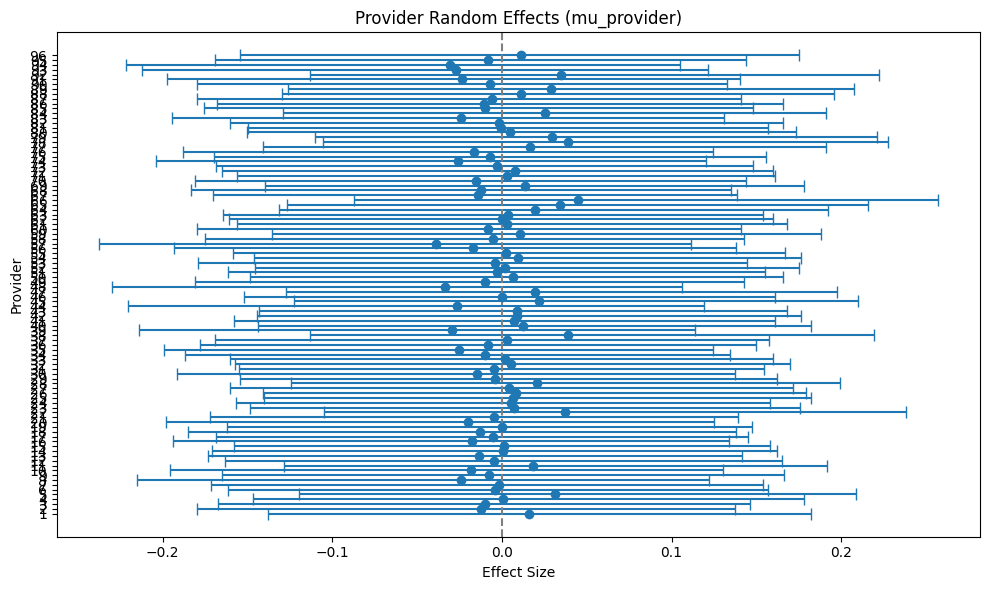

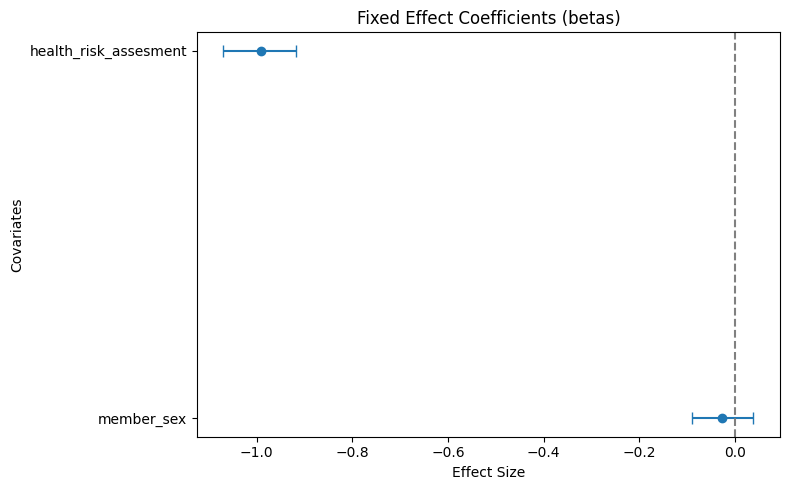

In [603]:
plot_model_coefficients(fit_data, provider_encoder, ["member_sex", "health_risk_assesment"])

In [604]:
results = az.summary(fit_data)

In [ ]:
# lets map back to provder effects 
mu_provider = fit_data.posterior["mu_provider"]
provider_means = mu_provider.mean(dim=("chain", "draw")).values
provider_ids = provider_encoder.inverse_transform(np.arange(len(provider_means)))

In [ ]:
provider_effects_df = pd.DataFrame({
    "provider_id": provider_ids,
    "mu_provider_mean": provider_means
})

In [ ]:
px.histogram(provider_effects_df.mu_provider_mean)

In [ ]:
provider_mu_hdi

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_provider[56],-0.038,0.089,-0.224,0.112,0.001,0.001,5727.0,5665.0,1.0
mu_provider[47],-0.033,0.087,-0.209,0.125,0.001,0.002,7199.0,5749.0,1.0
mu_provider[93],-0.033,0.084,-0.215,0.115,0.001,0.002,6538.0,4771.0,1.0
mu_provider[38],-0.030,0.085,-0.208,0.123,0.001,0.002,7597.0,5423.0,1.0
mu_provider[92],-0.029,0.088,-0.211,0.132,0.001,0.002,7689.0,5304.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_provider[91],0.036,0.087,-0.106,0.224,0.001,0.002,6563.0,5821.0,1.0
mu_provider[21],0.038,0.091,-0.118,0.234,0.001,0.002,6334.0,5534.0,1.0
mu_provider[37],0.039,0.087,-0.100,0.232,0.001,0.002,6400.0,5289.0,1.0
mu_provider[77],0.040,0.090,-0.105,0.237,0.001,0.002,6039.0,5107.0,1.0


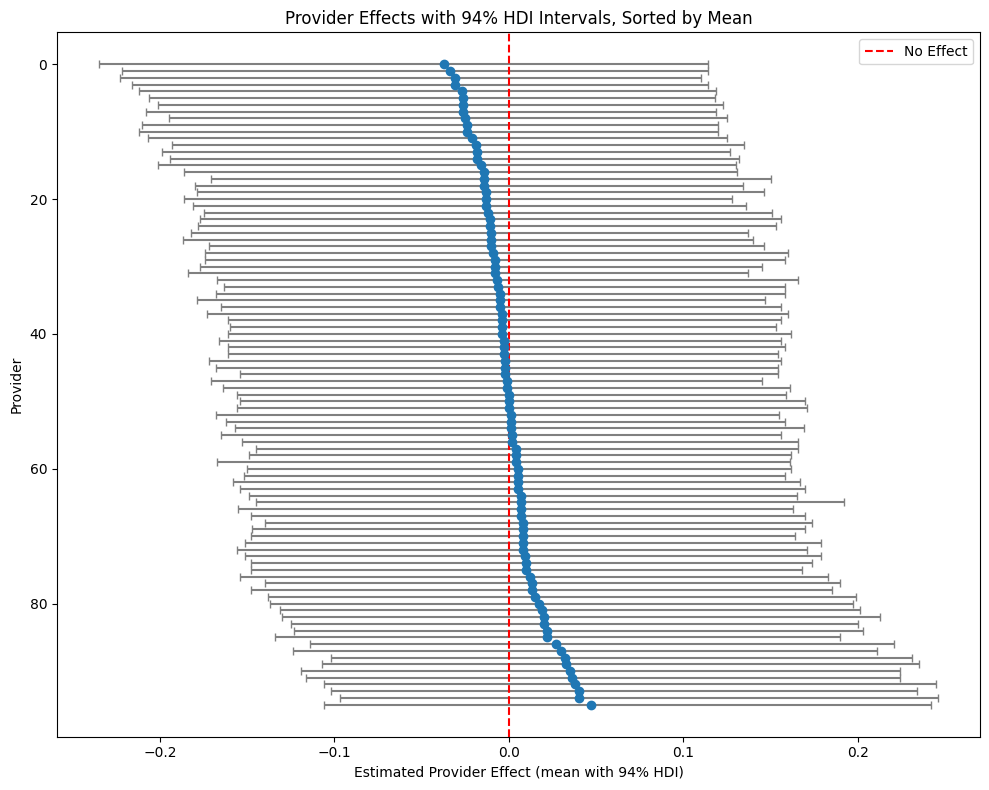

In [ ]:
provider_mu_hdi = az.summary(fit_data, var_names=["mu_provider"], hdi_prob=0.94)


provider_mu_hdi = provider_mu_hdi.sort_values("mean")

# Plot
plt.figure(figsize=(10, 8))
plt.errorbar(
    x=provider_mu_hdi["mean"],  # x-axis: mean effect
    y=range(len(provider_mu_hdi)),  # y-axis: providers, numeric order
    xerr=[provider_mu_hdi["mean"] - provider_mu_hdi["hdi_3%"], 
          provider_mu_hdi["hdi_97%"] - provider_mu_hdi["mean"]],  # error bars (HDI)
    fmt='o',
    ecolor='gray',
    capsize=3,
    linestyle='None'
)
plt.axvline(0, color='red', linestyle='--', label='No Effect')  # vertical line at 0
# Set y-ticks as provider names (sorted)
#plt.yticks(range(len(provider_mu_hdi)), provider_mu_hdi['provider'])
plt.xlabel("Estimated Provider Effect (mean with 94% HDI)")
plt.ylabel("Provider")
plt.title("Provider Effects with 94% HDI Intervals, Sorted by Mean")
plt.gca().invert_yaxis()  # Optional: to have highest effect at top
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# conclusion would be consider failure as a binary outcome there are some providers that have more of an effect on outcome than others within this cohort

In [ ]:
def provider_propensity_matching(
    df,
    covariates,
    outcome_col,
    provider_col,
    id_col=None,
    n_neighbors=3,
    caliper=0.05,
    min_sample_size=10,
    standardize=True,
):
    results = []
    providers = df[provider_col].unique()

    for provider in tqdm(providers, desc="Evaluating providers"):
        df_provider = df[df[provider_col] == provider].copy()
        # need to subsample the other providers to avoid biasing the propensity score model
        df_others = df[df[provider_col] != provider].copy().sample(300)

        if len(df_provider) < min_sample_size:
            continue

        # Combine for propensity score model
        df_provider['group'] = 1
        df_others['group'] = 0
        df_all = pd.concat([df_provider, df_others])

        # Optional: standardize covariates
        X = df_all[covariates].copy()

        if standardize:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        # Propensity score model
        ps_model = LogisticRegression(class_weight='balanced', max_iter=1000)
        ps_model.fit(X, df_all["group"])
        df_all["propensity_score"] = ps_model.predict_proba(X)[:, 1]

        # Split again with scores
        treated = df_all[df_all["group"] == 1]
        control = df_all[df_all["group"] == 0]

        # Nearest neighbor matching with caliper
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(control[["propensity_score"]])
        distances, indices = nn.kneighbors(treated[["propensity_score"]])

        matches = []
        for i, (dist, idxs) in enumerate(zip(distances, indices)):
            if dist[0] <= caliper:
                matches.append((treated.index[i], control.index[idxs[0]]))

        if not matches:
            continue

        # Create matched dataframe
        matched_rows = []
        for treat_idx, control_idx in matches:
            matched_rows.append(df_all.loc[treat_idx])
            matched_rows.append(df_all.loc[control_idx])

        df_matched = pd.DataFrame(matched_rows)

        # Count outcomes
        outcome_table = pd.crosstab(df_matched["group"], df_matched[outcome_col])

        # Skip if table is malformed
        if outcome_table.shape != (2, 2):
            continue

        # Fisher's exact test
        oddsratio, p_value = fisher_exact(outcome_table, alternative='greater')

        results.append({
            "provider": provider,
            "n_treated": len(treated),
            "n_matched": len(matched_rows) // 2,
            "odds_ratio": oddsratio,
            "p_value": p_value,
            "outcome_table": outcome_table.to_dict()
        })

    return pd.DataFrame(results)


In [ ]:
provider_propensity_matched_scores = provider_propensity_matching(
    data_outcome_compare,
    covariates=["member_sex", "health_risk_assesment"],
    outcome_col="outcome",
    provider_col="servicing_provider_id",
    id_col=None,
    n_neighbors=1,
    caliper=0.05,
    min_sample_size=10,
    standardize=False,
)

Evaluating providers: 100%|██████████| 96/96 [00:00<00:00, 186.38it/s]


In [ ]:
data_outcome_compare.dtypes

event_id                    int64
servicing_provider_id       int64
servicing_provider_name    object
treatment_date             object
member_id                   int64
member_age                  int64
member_sex                  int64
health_risk_assesment       int64
outcome                    object
dtype: object

In [ ]:
significant_effect_providers = provider_propensity_matched_scores.query("p_value < 0.05").sort_values("odds_ratio", ascending=False )

In [ ]:
print((len(significant_effect_providers)/ len(provider_propensity_matched_scores))*100)

13.541666666666666


In [ ]:
significant_effect_providers.sort_values("provider")

,provider,n_treated,n_matched,odds_ratio,p_value,outcome_table
51,1,46,46,3.653846,0.005977,"{'failure': {0: 38, 1: 26}, 'pass': {0: 8, 1: ..."
44,2,42,42,6.500000,0.002736,"{'failure': {0: 39, 1: 28}, 'pass': {0: 3, 1: ..."
34,4,38,38,4.317460,0.005816,"{'failure': {0: 32, 1: 21}, 'pass': {0: 6, 1: ..."
57,15,47,47,2.643357,0.024640,"{'failure': {0: 36, 1: 26}, 'pass': {0: 11, 1:..."
47,19,44,44,9.461538,0.000151,"{'failure': {0: 41, 1: 26}, 'pass': {0: 3, 1: ..."
73,32,40,40,11.158730,0.000052,"{'failure': {0: 37, 1: 21}, 'pass': {0: 3, 1: ..."
55,42,26,26,3.600000,0.037298,"{'failure': {0: 21, 1: 14}, 'pass': {0: 5, 1: ..."
38,45,47,47,2.226087,0.046710,"{'failure': {0: 32, 1: 23}, 'pass': {0: 15, 1:..."
4,59,34,34,3.250000,0.021597,"{'failure': {0: 26, 1: 17}, 'pass': {0: 8, 1: ..."
37,60,43,43,2.869565,0.020427,"{'failure': {0: 33, 1: 23}, 'pass': {0: 10, 1:..."


In [ ]:
outcomes_df = pd.DataFrame(outcomes_prop_xprovider, index=outcomesxprovider.index)
outcomes_df_odds = outcomes_df.merge(provider_propensity_matched_scores[["provider", "odds_ratio", "p_value"]],left_on="servicing_provider_id", right_on="provider").sort_values("odds_ratio", ascending=False)
outcomes_df_odds.rename(columns={0: "proportion_failed"}, inplace=True)

In [ ]:
px.scatter(outcomes_df_odds, x="odds_ratio", y="proportion_failed", color="p_value", hover_data=["provider"], title="Provider Outcomes with Propensity Score Matching")

In [ ]:
# what about doing a log reg just on the health risk analysis and provider to see if there is a gain in information
outcomes_df_odds_hra = outcomes_df_odds.merge(data_outcome_compare[["servicing_provider_id", "health_risk_assesment", "member_id", "outcome"]], left_on="provider", right_on="servicing_provider_id")
outcomes_df_odds_hra_failed = outcomes_df_odds_hra.query("outcome == 'failure'").groupby(["provider", "odds_ratio"]).health_risk_assesment.mean().reset_index()
print(outcomes_df_odds_hra_failed)

outcomes_df_odds_hra_failed[["odds_ratio", "health_risk_assesment"]].corr()
px.scatter(outcomes_df_odds_hra_failed, x="odds_ratio", y="health_risk_assesment", hover_data=["provider"], title="Provider Outcomes with Propensity Score Matching")


    provider  odds_ratio  health_risk_assesment
0          1    3.653846               6.653846
1          2    6.500000               6.321429
2          3    2.094545               6.000000
3          4    4.317460               5.238095
4          5    1.455026               6.611111
..       ...         ...                    ...
91        92    1.809211               6.947368
92        93    1.887097               5.774194
93        94    0.405405               5.621622
94        95    0.666667               5.791667
95        96    0.728000               5.720000

[96 rows x 3 columns]


In [ ]:
# all the above was done under the assumption failure was binary... 
# however we might want to consider a survival analysis given that we have the time of each visit
# although we dont have the time of the failure event  
# add this into what we would do if we had the data (maybe simulate?)
# TODO simulate this data if we can 

In [ ]:
# TODO try a reduced model provider and or health risk assessment
# if we want to compare the full model with the reduced model we can use WAIC
#az.compare({"full": idata1, "reduced": idata2}, method="WAIC")

# Covariate adjusted emprirical null 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from tqdm import tqdm

def empirical_null_provider_failures(df, target_col, provider_col, covariates, n_simulations=1000, random_state=42):
    """
    Compare observed provider failure rates to an empirical null conditioned on covariates.

    Parameters:
    - df: DataFrame with data
    - target_col: column name for binary outcome (0/1)
    - provider_col: column name for provider/grouping
    - covariates: list of covariates to condition on
    - n_simulations: number of simulations for null distribution

    Returns:
    - results_df: DataFrame with observed, expected mean, p-value, and CI per provider
    """
    df = df.copy()
    df = df.dropna(subset=[target_col] + covariates + [provider_col])
    # binarize target column 
    df[target_col] = df[target_col].apply(lambda x: 1 if x == 'failure' else 0)
    # Fit logistic regression to estimate P(failure | covariates)
    X = df[covariates]
    y = df[target_col]
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    df['pred_prob'] = model.predict_proba(X)[:, 1]

    provider_results = []

    for provider, group in tqdm(df.groupby(provider_col), desc="Simulating nulls by provider"):
        n = len(group)
        # true failure rate per provider
        observed_fail_rate = group[target_col].mean()
        predicted_probs = group['pred_prob'].values

        # Simulate n_simulations provider-level failure rates
        sim_fail_rates = []
        for _ in range(n_simulations):
            # simulate outcomes based on predicted probabilities for that providers patients based only on covariates
            simulated_outcomes = np.random.binomial(n=1, p=predicted_probs)
            sim_fail_rates.append(simulated_outcomes.mean())

        sim_fail_rates = np.array(sim_fail_rates)
        # determine p-value and confidence intervals
        lower = np.percentile(sim_fail_rates, 2.5)
        upper = np.percentile(sim_fail_rates, 97.5)
        p_value = (np.sum(sim_fail_rates >= observed_fail_rate) + 1) / (n_simulations + 1) if observed_fail_rate > sim_fail_rates.mean() else (np.sum(sim_fail_rates <= observed_fail_rate) + 1) / (n_simulations + 1)

        provider_results.append({
            "provider": provider,
            "observed_failure_rate": observed_fail_rate,
            "expected_mean": sim_fail_rates.mean(),
            "lower_95_CI": lower,
            "upper_95_CI": upper,
            "p_value": p_value
        })

    results_df = pd.DataFrame(provider_results)
    return results_df


In [615]:
empirical_null_covariate_test = empirical_null_provider_failures(data_outcome_compare, "outcome", "servicing_provider_id", ["member_sex", "health_risk_assesment"])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered

      member_sex  health_risk_assesment
0              0                      7
1              0                      3
2              1                      2
3              0                      4
4              1                      7
...          ...                    ...
4242           0                      9
4243           0                      1
4244           0                      8
4245           0                      8
4246           1                      3

[4247 rows x 2 columns]


Simulating nulls by provider: 100%|██████████| 96/96 [00:00<00:00, 153.26it/s]


In [622]:
# addressing issues in log reg above, could be because all females with a health risk assesment of 1 all pass 
# and there are no men with a health risk assessment of 1
data_outcome_compare.groupby(["member_sex", "health_risk_assesment", "outcome"]).member_id.count().sort_index()

member_sex  health_risk_assesment  outcome
0           1                      pass       133
            2                      failure     31
                                   pass       258
            3                      failure    131
                                   pass       191
            4                      failure    180
                                   pass       131
            5                      failure    168
                                   pass        91
            6                      failure    206
                                   pass        95
            7                      failure    201
                                   pass        72
            8                      failure    145
                                   pass        42
            9                      failure     50
                                   pass        13
1           2                      failure     14
                                   pass       127
       

In [613]:
empirical_null_covariate_test.query("p_value < 0.05").sort_values("observed_failure_rate", ascending=False)

,provider,observed_failure_rate,expected_mean,lower_95_CI,upper_95_CI,p_value
56,57,0.723404,0.591532,0.468085,0.723404,0.030969
37,38,0.491803,0.603951,0.491803,0.704918,0.033966
91,92,0.463415,0.597537,0.463415,0.731707,0.028971
21,22,0.431818,0.566636,0.431818,0.704545,0.032967
77,78,0.431818,0.579273,0.453977,0.727273,0.025974
88,89,0.431818,0.543023,0.409091,0.681818,0.049950
4,5,0.418605,0.540628,0.418605,0.674419,0.049950
65,66,0.377778,0.545622,0.422222,0.688889,0.011988
64,65,0.372093,0.499953,0.372093,0.627907,0.035964


# data we wish we had 
- BMI
- ZIPCODE 
- Medications 
- Time of follow up failure or last followup 

In [624]:
import pandas as pd
import numpy as np

def generate_later_timestamp_column(df, reference_col, new_col='later_timestamp', min_days=1, max_days=30, seed=None):
    """
    Adds a new timestamp column where each value is after the corresponding value in `reference_col`.

    Parameters:
    - df: pandas DataFrame
    - reference_col: name of the column with base timestamps
    - new_col: name of the new column to create
    - min_days: minimum number of days after the reference date
    - max_days: maximum number of days after the reference date
    - seed: random seed for reproducibility

    Returns:
    - df with the new column added
    """
    if seed is not None:
        np.random.seed(seed)

    # Ensure the reference column is in datetime format
    df = df.copy()
    df[reference_col] = pd.to_datetime(df[reference_col])

    # Generate random number of days to add
    days_to_add = np.random.randint(min_days, max_days + 1, size=len(df))
    df[new_col] = df[reference_col] + pd.to_timedelta(days_to_add, unit='D')

    return df


In [629]:
data_time_synth = generate_later_timestamp_column(data, "treatment_date", new_col='followup_date', min_days=30, max_days=360, seed=None)

/var/folders/y_/kv1q88q92mz481dwnsnd3sk00000gn/T/ipykernel_52569/200865074.py:24: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
# lets create a survival analysis to determine the effect of provider and covariates on time to failure

def cox_provider_effect(
    df, 
    start_col,
    end_col, 
    event_col, 
    provider_col, 
    covariates=['member_sex', 'health_risk_assesment']
):
    """
    Fits a Cox proportional hazards model with provider as a factor and specified covariates.

    Parameters:
    - df: pandas DataFrame with survival data
    - duration_col: name of the time-to-event column
    - event_col: name of the event indicator column (1=event, 0=censor)
    - provider_col: name of the provider categorical column
    - covariates: list of covariate column names to adjust for

    Returns:
    - model: fitted lifelines CoxPHFitter object
    - summary_df: DataFrame with model summary including provider hazard ratios and covariates
    """
    df = df.copy()
    df[event_col] = df[event_col].apply(lambda x: 1 if x == 'failure' else 0)
    df["duration"] = df[end_col] - df[start_col]
    df["duration"] = df["duration"].dt.days  # Convert timedelta to days
    
    # Convert provider to categorical and create dummies (one-hot encode, drop one to avoid collinearity)
    provider_dummies = pd.get_dummies(df[provider_col], prefix='provider', drop_first=True)

    # Combine covariates
    X = pd.concat([provider_dummies, df[covariates]], axis=1)

    # Combine with duration and event columns
    survival_df = pd.concat([df[["duration", event_col]], X], axis=1)

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(survival_df, duration_col="duration", event_col=event_col)

    return cph, cph.summary

In [666]:
def bayesian_cox_model(
    df,
    start_col,
    end_col,
    event_col,
    provider_col,
    covariates=["member_sex", "health_risk_assesment"],
    draws=1000,
    tune=1000,
    chains=4,
):
    """
    Fit a Bayesian Cox-style survival model using exponential hazards with right-censoring.
    """

    df = df.copy()

    # Binary outcome: 1 = failure, 0 = censored
    df[event_col] = df[event_col].apply(lambda x: 1 if x == "failure" else 0)

    # Duration in days
    df["duration"] = (df[end_col] - df[start_col]).dt.days
    df = df.dropna(subset=["duration", event_col] + covariates)

    # Encode providers
    provider_codes, provider_names = pd.factorize(df[provider_col])
    n_providers = len(provider_names)

    # Design matrix
    X = dmatrix("0 + " + " + ".join(covariates), df, return_type="dataframe")
    X = (X - X.mean()) / X.std()

    duration = df["duration"].values
    event = df[event_col].values
    provider_codes = np.asarray(provider_codes)

    with pm.Model() as model:
        # Priors
        log_h0 = pm.Normal("log_h0", mu=0, sigma=5)
        beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
        sigma_provider = pm.HalfNormal("sigma_provider", sigma=1)
        provider_offset = pm.Normal("provider_offset", mu=0, sigma=1, shape=n_providers)
        provider_effect = pm.Deterministic("provider_effect", provider_offset * sigma_provider)

        # Linear predictor and hazard
        linear_pred = pm.math.dot(X.values, beta) + provider_effect[provider_codes]
        hazard = pm.math.exp(log_h0 + linear_pred)

        # Custom log-likelihood for exponential survival model with censoring
        def logp_exp_survival(t, event, hazard):
            # log-likelihood:
            # for events:     log(h) - h * t
            # for censored:   - h * t
            loglik = event * pm.math.log(hazard) - hazard * t
            return pm.math.sum(loglik)

        # Use a custom distribution to define the likelihood
        pm.Potential("likelihood", logp_exp_survival(duration, event, hazard))

        idata = pm.sample(draws=draws, tune=tune, chains=chains, target_accept=0.9, return_inferencedata=True)

    return model, idata, provider_names

In [668]:
coxmodel, coxdata, provider_names = bayesian_cox_model(data_time_synth, "treatment_date","followup_date", "outcome", "servicing_provider_id", covariates=['member_sex', 'health_risk_assesment'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_h0, beta, sigma_provider, provider_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [ ]:
def plot_bayesian_cox_effects(idata, provider_names, covariate_names, hdi_prob=0.95):
    import matplotlib.pyplot as plt
    import arviz as az

    # PROVIDER EFFECTS
    provider_effects = idata.posterior["provider_effect"]
    provider_hdi = az.hdi(provider_effects, hdi_prob=hdi_prob)
    provider_means = provider_effects.mean(dim=["chain", "draw"])

    provider_dim = list(provider_means.dims)[0]  

    plt.figure(figsize=(10, len(provider_names) * 0.3 + 3))
    for i, name in enumerate(provider_names):
        mean_val = provider_means.sel({provider_dim: i}).values.item()
        lower = provider_hdi.sel({provider_dim: i, "hdi": "lower"})["provider_effect"]
        upper = provider_hdi.sel({provider_dim: i, "hdi": "higher"})["provider_effect"]
        plt.errorbar(mean_val, i, xerr=[[mean_val - lower], [upper - mean_val]], fmt="o", color="black")

    plt.axvline(0, linestyle="--", color="red", alpha=0.5)
    plt.yticks(range(len(provider_names)), provider_names)
    plt.title("Provider Effects (Posterior Mean ± 95% HDI)")
    plt.xlabel("Effect on log hazard")
    plt.tight_layout()
    plt.show()

    # COVARIATE EFFECTS
    beta_effects = idata.posterior["beta"]
    beta_means = beta_effects.mean(dim=["chain", "draw"])
    beta_hdi = az.hdi(beta_effects, hdi_prob=hdi_prob)
    beta_dim = list(beta_means.dims)[0]

    plt.figure(figsize=(8, len(covariate_names) * 0.6 + 2))
    for i, cov in enumerate(covariate_names):
        mean_val = beta_means.sel({beta_dim: i}).values.item()
        lower = beta_hdi.sel({beta_dim: i, "hdi": "lower"})["beta"]
        upper = beta_hdi.sel({beta_dim: i, "hdi": "higher"})["beta"]
        plt.errorbar(mean_val, i, xerr=[[mean_val - lower], [upper - mean_val]], fmt="o", color="blue")

    plt.axvline(0, linestyle="--", color="red", alpha=0.5)
    plt.yticks(range(len(covariate_names)), covariate_names)
    plt.title("Covariate Effects (Posterior Mean ± 95% HDI)")
    plt.xlabel("Effect on log hazard")
    plt.tight_layout()
    plt.show()
